In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

import os
from copy import deepcopy

from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import numpy as np
import torch
from agent import DQNAgent
from humemai.utils import read_yaml
from humemai.policy import (
    answer_question,
    argmax,
    encode_observation,
    explore,
    manage_memory,
)


def process_room_observations(
    agent: DQNAgent, observations_room: list
) -> tuple[list, list, list, list]:
    """Process room observations. This is used when training an exploration policy.

    Args:
        DQNAgent: agent
        observations_room: observations["room"] from the environment

    Returns:
        tuple[list, list, list]: states_all, attention_all, q_values_all, actions_all

    """
    states_all = []
    attention_all = []
    q_values_all = []
    actions_all = []

    for obs in observations_room:
        encode_observation(agent.memory_systems, obs)
        state = agent.memory_systems.return_as_a_dict_list()
        states_all.append(deepcopy(state))
        with torch.no_grad():
            lstm_out, attention = agent.lstm_mm(
                np.array([state]), agent.memory_types["mm"]
            )
            attention = attention.squeeze(0).sum(dim=0).tolist()
            q_values = agent.mlp_mm(lstm_out).detach().cpu().tolist()[0]

            action = argmax(q_values)

            manage_memory(
                memory_systems=agent.memory_systems,
                policy=agent.action2str["mm"][action],
                split_possessive=False,
            )

        attention_all.append(deepcopy(attention))
        q_values_all.append(deepcopy(q_values))
        actions_all.append(deepcopy(action))
    agent.memory_systems.semantic.decay()

    return states_all, attention_all, q_values_all, actions_all


def explore(agent: DQNAgent) -> tuple[list, list, list, list]:
    """Explore the environment using the exploration policy.

    Args:
        DQNAgent: agent

    Returns:
        tuple[dict, list, list]: state, attention, q_values, action

    """
    state = agent.get_deepcopied_memory_state()
    with torch.no_grad():
        lstm_out, attention = agent.lstm_explore(
            np.array([state]), agent.memory_types["explore"]
        )
        attention = attention.squeeze(0).sum(dim=0).tolist()
        q_values = agent.mlp_explore(lstm_out).detach().cpu().tolist()[0]
        action = argmax(q_values)

    return state, attention, q_values, action


def load_models(agent: DQNAgent, root_path: str) -> None:
    """Load models from a given root_path.

    Args:
        DQNAgent: agent
        root_path: root path

    """
    for checkpoint_path in glob(os.path.join(root_path, "*/*/*/*.pt")):
        if "mm" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_mm.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_mm.eval()
            for param in agent.lstm_mm.parameters():
                param.requires_grad = False
        elif "mm" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_mm.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_mm.eval()
            for param in agent.mlp_mm.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "lstm" in checkpoint_path:
            agent.lstm_explore.load_state_dict(torch.load(checkpoint_path))
            agent.lstm_explore.eval()
            for param in agent.lstm_explore.parameters():
                param.requires_grad = False
        elif "explore" in checkpoint_path and "mlp" in checkpoint_path:
            agent.mlp_explore.load_state_dict(torch.load(checkpoint_path))
            agent.mlp_explore.eval()
            for param in agent.mlp_explore.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unknown checkpoint path")


root_path = "training-results/non-equal-object-probs/dqn/room_size=xl-different-prob/capacity=24/episodic=12_semantic=12/pretrain_semantic=False/2024-07-03 13:06:14.393364"
train_params_path = os.path.join(root_path, "train.yaml")
train_params = read_yaml(train_params_path)
train_params["default_root_dir"] = "training-results/TRASH"
# train_params["semantic_decay_factor"] = 0.8

num_tests = 20

stats_interest = [
    {
        "mm": {"state": [], "attention": [], "q_value": [], "action": []},
        "explore": {"state": [], "attention": [], "q_value": [], "action": []},
        "score": None,
    }
    for _ in range(num_tests)
]

for idx in tqdm(range(num_tests)):
    train_params["train_seed"] = idx
    train_params["test_seed"] = idx
    agent = DQNAgent(**train_params)
    load_models(agent, root_path)
    new_episode_starts = True
    score = 0
    while True:
        if new_episode_starts:
            agent.init_memory_systems()
            observations, info = agent.env.reset()
            done = False
            states_all, attention_all, q_values_all, actions_all = (
                process_room_observations(agent, observations["room"])
            )
            stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
            stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
            stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
            stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            new_episode_starts = False

        else:
            state, attention, q_values, action = explore(agent)
            stats_interest[idx]["explore"]["state"].append(deepcopy(state))
            stats_interest[idx]["explore"]["attention"].append(deepcopy(attention))
            stats_interest[idx]["explore"]["q_value"].append(deepcopy(q_values))
            stats_interest[idx]["explore"]["action"].append(deepcopy(action))

            answers = [
                answer_question(
                    agent.memory_systems, agent.qa_function, q, split_possessive=False
                )
                for q in observations["questions"]
            ]

            action_pair = (answers, agent.action2str["explore"][action])
            (
                observations,
                reward,
                done,
                truncated,
                info,
            ) = agent.env.step(action_pair)
            done = done or truncated

            if not done:
                states_all, attention_all, q_values_all, actions_all = (
                    process_room_observations(agent, observations["room"])
                )
                stats_interest[idx]["mm"]["state"].extend(deepcopy(states_all))
                stats_interest[idx]["mm"]["attention"].extend(deepcopy(attention_all))
                stats_interest[idx]["mm"]["q_value"].extend(deepcopy(q_values_all))
                stats_interest[idx]["mm"]["action"].extend(deepcopy(actions_all))

            score += reward

        if done:
            break
    stats_interest[idx]["score"] = score

    agent.remove_results_from_disk()

/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/20 [00:00<?, ?it/s]/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/home/tk/.virtualenvs/agent-room-env-v2-

Running on cpu


  5%|▌         | 1/20 [00:06<01:58,  6.26s/it]

Running on cpu


 10%|█         | 2/20 [00:15<02:22,  7.91s/it]

Running on cpu


 15%|█▌        | 3/20 [00:22<02:10,  7.67s/it]

Running on cpu


 20%|██        | 4/20 [00:31<02:12,  8.27s/it]

Running on cpu


 25%|██▌       | 5/20 [00:43<02:21,  9.42s/it]

Running on cpu


 30%|███       | 6/20 [00:50<02:02,  8.73s/it]

Running on cpu


 35%|███▌      | 7/20 [01:01<02:03,  9.50s/it]

Running on cpu


 40%|████      | 8/20 [01:07<01:40,  8.35s/it]

Running on cpu


 45%|████▌     | 9/20 [01:12<01:20,  7.36s/it]

Running on cpu


 50%|█████     | 10/20 [01:18<01:07,  6.75s/it]

Running on cpu


 55%|█████▌    | 11/20 [01:23<00:57,  6.39s/it]

Running on cpu


 60%|██████    | 12/20 [01:31<00:54,  6.80s/it]

Running on cpu


 65%|██████▌   | 13/20 [01:39<00:49,  7.11s/it]

Running on cpu


 70%|███████   | 14/20 [01:46<00:43,  7.22s/it]

Running on cpu


 75%|███████▌  | 15/20 [01:52<00:33,  6.67s/it]

Running on cpu


 80%|████████  | 16/20 [01:57<00:25,  6.28s/it]

Running on cpu


 85%|████████▌ | 17/20 [01:59<00:15,  5.03s/it]

Running on cpu


 90%|█████████ | 18/20 [02:04<00:09,  4.88s/it]

Running on cpu


 95%|█████████▌| 19/20 [02:10<00:05,  5.23s/it]

Running on cpu


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


In [2]:
from collections import Counter

for idx in range(num_tests):
    print(
        idx,
        ": ",
        stats_interest[idx]["score"],
        "\t",
        Counter(stats_interest[idx]["mm"]["action"]),
        Counter(stats_interest[idx]["explore"]["action"]),
    )

0 :  105 	 Counter({1: 447, 2: 67, 0: 12}) Counter({1: 99, 2: 1})
1 :  93 	 Counter({1: 380, 2: 119, 0: 11}) Counter({1: 99, 2: 1})
2 :  106 	 Counter({1: 423, 2: 74, 0: 11}) Counter({1: 99, 2: 1})
3 :  69 	 Counter({1: 412, 2: 135, 0: 23}) Counter({1: 99, 2: 1})
4 :  70 	 Counter({1: 466, 2: 53, 0: 46}) Counter({1: 99, 2: 1})
5 :  233 	 Counter({1: 355, 2: 166, 0: 12}) Counter({1: 99, 2: 1})
6 :  256 	 Counter({1: 480, 0: 85, 2: 40}) Counter({1: 99, 2: 1})
7 :  107 	 Counter({1: 440, 2: 63, 0: 11}) Counter({1: 99, 2: 1})
8 :  93 	 Counter({1: 347, 2: 170, 0: 12}) Counter({1: 99, 2: 1})
9 :  109 	 Counter({1: 526, 2: 63, 0: 18}) Counter({1: 99, 2: 1})
10 :  192 	 Counter({1: 324, 2: 194, 0: 11}) Counter({1: 99, 2: 1})
11 :  228 	 Counter({1: 543, 2: 45, 0: 27}) Counter({1: 99, 2: 1})
12 :  202 	 Counter({1: 516, 2: 83, 0: 16}) Counter({1: 99, 2: 1})
13 :  275 	 Counter({1: 428, 2: 148, 0: 11}) Counter({1: 99, 2: 1})
14 :  242 	 Counter({1: 414, 2: 142, 0: 17}) Counter({1: 99, 2: 1})
15

In [3]:
idx_of_interest = 11

In [4]:
[(idx, foo) for idx, foo in enumerate(agent.env.hidden_global_states_all)]

/home/tk/.virtualenvs/agent-room-env-v2-lstm/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.hidden_global_states_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.hidden_global_states_all` for environment variables or `env.get_wrapper_attr('hidden_global_states_all')` that will search the reminding wrappers.
  logger.warn(


[(0,
  [['room_000', 'north', 'wall', 0],
   ['room_000', 'east', 'room_001', 0],
   ['room_000', 'south', 'room_004', 0],
   ['room_000', 'west', 'wall', 0],
   ['room_001', 'north', 'wall', 0],
   ['room_001', 'east', 'wall', 0],
   ['room_001', 'south', 'room_005', 0],
   ['room_001', 'west', 'room_000', 0],
   ['room_002', 'north', 'wall', 0],
   ['room_002', 'east', 'room_003', 0],
   ['room_002', 'south', 'room_008', 0],
   ['room_002', 'west', 'wall', 0],
   ['room_003', 'north', 'wall', 0],
   ['room_003', 'east', 'wall', 0],
   ['room_003', 'south', 'room_009', 0],
   ['room_003', 'west', 'room_002', 0],
   ['room_004', 'north', 'room_000', 0],
   ['room_004', 'east', 'room_005', 0],
   ['room_004', 'south', 'wall', 0],
   ['room_004', 'west', 'wall', 0],
   ['room_005', 'north', 'room_001', 0],
   ['room_005', 'east', 'room_006', 0],
   ['room_005', 'south', 'wall', 0],
   ['room_005', 'west', 'room_004', 0],
   ['room_006', 'north', 'wall', 0],
   ['room_006', 'east', 'room_

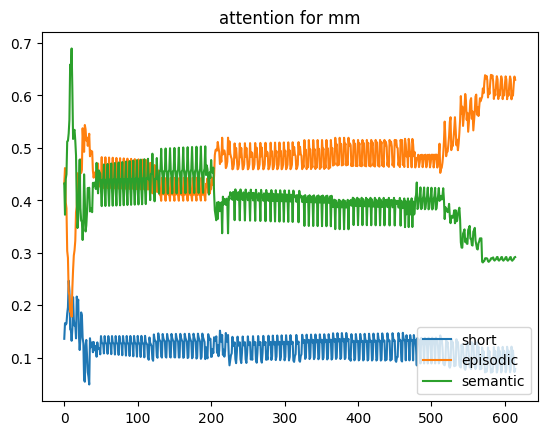

In [5]:
for i in range(len(agent.memory_types["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["attention"]],
        label=agent.memory_types["mm"][i],
    )

plt.legend(loc="lower right");
plt.title("attention for mm");

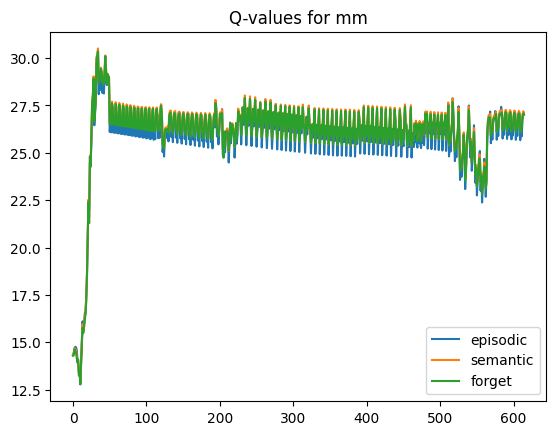

In [6]:
for i in range(len(agent.action2str["mm"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["mm"]["q_value"]],
        label=agent.action2str["mm"][i],
    )

plt.legend(loc="lower right");
plt.title("Q-values for mm");

In [7]:
[
    (idx, agent.action2str["mm"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["action"])
]

[(0, 'semantic'),
 (1, 'episodic'),
 (2, 'semantic'),
 (3, 'episodic'),
 (4, 'episodic'),
 (5, 'episodic'),
 (6, 'episodic'),
 (7, 'semantic'),
 (8, 'episodic'),
 (9, 'semantic'),
 (10, 'semantic'),
 (11, 'semantic'),
 (12, 'semantic'),
 (13, 'episodic'),
 (14, 'semantic'),
 (15, 'semantic'),
 (16, 'episodic'),
 (17, 'semantic'),
 (18, 'episodic'),
 (19, 'semantic'),
 (20, 'semantic'),
 (21, 'semantic'),
 (22, 'episodic'),
 (23, 'semantic'),
 (24, 'episodic'),
 (25, 'semantic'),
 (26, 'semantic'),
 (27, 'semantic'),
 (28, 'semantic'),
 (29, 'semantic'),
 (30, 'semantic'),
 (31, 'semantic'),
 (32, 'semantic'),
 (33, 'semantic'),
 (34, 'semantic'),
 (35, 'forget'),
 (36, 'semantic'),
 (37, 'forget'),
 (38, 'semantic'),
 (39, 'semantic'),
 (40, 'semantic'),
 (41, 'semantic'),
 (42, 'semantic'),
 (43, 'semantic'),
 (44, 'semantic'),
 (45, 'semantic'),
 (46, 'semantic'),
 (47, 'semantic'),
 (48, 'semantic'),
 (49, 'semantic'),
 (50, 'semantic'),
 (51, 'semantic'),
 (52, 'semantic'),
 (53, '

In [8]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["mm"]["state"])
]

[(0,
  0,
  0,
  {'episodic': [],
   'semantic': [],
   'short': [['room_000', 'north', 'wall', 0]]}),
 (1,
  0,
  1,
  {'episodic': [],
   'semantic': [['room_000', 'north', 'wall', 1]],
   'short': [['room_000', 'east', 'room_001', 0]]}),
 (2,
  1,
  1,
  {'episodic': [['room_000', 'east', 'room_001', 0]],
   'semantic': [['room_000', 'north', 'wall', 1]],
   'short': [['room_000', 'south', 'room_004', 0]]}),
 (3,
  1,
  2,
  {'episodic': [['room_000', 'east', 'room_001', 0]],
   'semantic': [['room_000', 'south', 'room_004', 1],
    ['room_000', 'north', 'wall', 1]],
   'short': [['room_000', 'west', 'wall', 0]]}),
 (4,
  2,
  2,
  {'episodic': [['room_000', 'east', 'room_001', 0],
    ['room_000', 'west', 'wall', 0]],
   'semantic': [['room_000', 'south', 'room_004', 1],
    ['room_000', 'north', 'wall', 1]],
   'short': [['agent', 'atlocation', 'room_000', 0]]}),
 (5,
  3,
  2,
  {'episodic': [['room_000', 'east', 'room_001', 0],
    ['room_000', 'west', 'wall', 0],
    ['agent', 

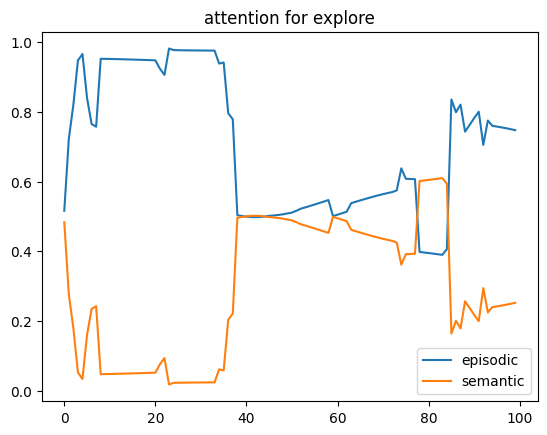

In [9]:
for i in range(len(agent.memory_types["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["attention"]],
        label=agent.memory_types["explore"][i],
    )

plt.legend(loc="lower right");
plt.title("attention for explore");

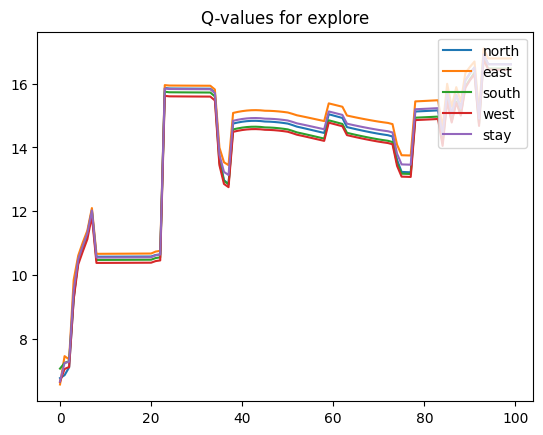

In [10]:
for i in range(len(agent.action2str["explore"])):
    plt.plot(
        [foo[i] for foo in stats_interest[idx_of_interest]["explore"]["q_value"]],
        label=agent.action2str["explore"][i],
    )

plt.legend(loc="upper right");
plt.title("Q-values for explore");

In [11]:
[
    (idx, agent.action2str["explore"][foo])
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["action"])
]

[(0, 'south'),
 (1, 'east'),
 (2, 'east'),
 (3, 'east'),
 (4, 'east'),
 (5, 'east'),
 (6, 'east'),
 (7, 'east'),
 (8, 'east'),
 (9, 'east'),
 (10, 'east'),
 (11, 'east'),
 (12, 'east'),
 (13, 'east'),
 (14, 'east'),
 (15, 'east'),
 (16, 'east'),
 (17, 'east'),
 (18, 'east'),
 (19, 'east'),
 (20, 'east'),
 (21, 'east'),
 (22, 'east'),
 (23, 'east'),
 (24, 'east'),
 (25, 'east'),
 (26, 'east'),
 (27, 'east'),
 (28, 'east'),
 (29, 'east'),
 (30, 'east'),
 (31, 'east'),
 (32, 'east'),
 (33, 'east'),
 (34, 'east'),
 (35, 'east'),
 (36, 'east'),
 (37, 'east'),
 (38, 'east'),
 (39, 'east'),
 (40, 'east'),
 (41, 'east'),
 (42, 'east'),
 (43, 'east'),
 (44, 'east'),
 (45, 'east'),
 (46, 'east'),
 (47, 'east'),
 (48, 'east'),
 (49, 'east'),
 (50, 'east'),
 (51, 'east'),
 (52, 'east'),
 (53, 'east'),
 (54, 'east'),
 (55, 'east'),
 (56, 'east'),
 (57, 'east'),
 (58, 'east'),
 (59, 'east'),
 (60, 'east'),
 (61, 'east'),
 (62, 'east'),
 (63, 'east'),
 (64, 'east'),
 (65, 'east'),
 (66, 'east'),
 (67

In [12]:
[
    (idx, len(foo["episodic"]), len(foo["semantic"]), foo)
    for idx, foo in enumerate(stats_interest[idx_of_interest]["explore"]["state"])
]

[(0,
  5,
  2,
  {'episodic': [['room_000', 'east', 'room_001', 0],
    ['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['dep_007', 'atlocation', 'room_000', 0],
    ['dep_001', 'atlocation', 'room_000', 0]],
   'semantic': [['room_000', 'south', 'room_004', 1],
    ['room_000', 'north', 'wall', 1]],
   'short': []}),
 (1,
  6,
  6,
  {'episodic': [['room_000', 'east', 'room_001', 0],
    ['room_000', 'west', 'wall', 0],
    ['agent', 'atlocation', 'room_000', 0],
    ['dep_007', 'atlocation', 'room_000', 0],
    ['dep_001', 'atlocation', 'room_000', 0],
    ['room_004', 'east', 'room_005', 1]],
   'semantic': [['room_004', 'north', 'room_000', 1],
    ['room_000', 'south', 'room_004', 1],
    ['agent', 'atlocation', 'room_004', 1],
    ['room_004', 'west', 'wall', 1],
    ['room_004', 'south', 'wall', 1],
    ['room_000', 'north', 'wall', 1]],
   'short': []}),
 (2,
  8,
  9,
  {'episodic': [['room_000', 'east', 'room_001', 0],
    ['room_000', 'west',